# Problema 1 - Audio MNIST

## Descripción:

En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos
hablados del 0 al 9.

## Dataset:

https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos,
50 clips por dígito por locutor

## Objetivo:
 
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes
neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben
entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de
clasificación

Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
● Modelo convolucional sobre los espectrogramas de los clips.
● Modelo recurrente sobre los espectrogramas de los clips.


### Importar librerías

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras import models
import seaborn as sns

2025-06-10 13:44:20.221689: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 13:44:20.538838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


2025-06-09 19:45:30.421252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 19:45:30.455613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 19:45:30.456041: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 19:45:30.464401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-09 19:45:30.464987: I tensorflow/compile

### Descargar dataset:

In [3]:
df_train, df_val  = tfds.load('spoken_digit', with_info=False, as_supervised=False,shuffle_files=True,split=['train[:80%]', 'train[80%:]'])

### Normlaizar los audios

In [4]:
def normalize_audio_length(example, target_length=8000):
    audio = example['audio']
    current_length = tf.shape(audio)[0]
    
    # Padding si es más corto
    padding_needed = tf.maximum(target_length - current_length, 0)
    audio = tf.pad(audio, [[0, padding_needed]])
    
    # Truncar si es más largo
    audio = audio[:target_length]
    
    # Mantener todas las claves originales (label, filename, etc.)
    return {
        'audio': audio,
        'label': example['label'],
        'audio/filename': example['audio/filename'],
    }

# Aplicar la normalización
df_train_norm = df_train.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)
df_val_norm = df_val.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)

# Verificar un ejemplo
for example in df_train_norm.take(1):
    print("Audio shape:", example['audio'].shape)  # Debe ser (8000,)
    print("Label:", example['label'].numpy())
    print("Filename:", example['audio/filename'].numpy().decode())

Audio shape: (8000,)
Label: 2
Filename: 2_nicolas_23.wav


2025-06-09 19:45:31.104082: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  waveform = tf.cast(waveform, tf.float32)
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

### Escuchar distintos ejemplos de numeros de Dataset

In [6]:
for example_audio in df_train_norm.take(3):
    audio = tf.cast(example_audio['audio'], float)
    waveform = audio
    spectrogram = get_spectrogram(waveform)

    print('Label:', int(example_audio['label']))
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=8000))

Label: 2
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 1
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


Label: 9
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


2025-06-09 19:45:31.267643: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Grafico de ejemplos de las seniales de onda de los numeros

In [7]:
df_train_norm

<_ParallelMapDataset element_spec={'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None)}>

2025-06-09 19:45:31.451218: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


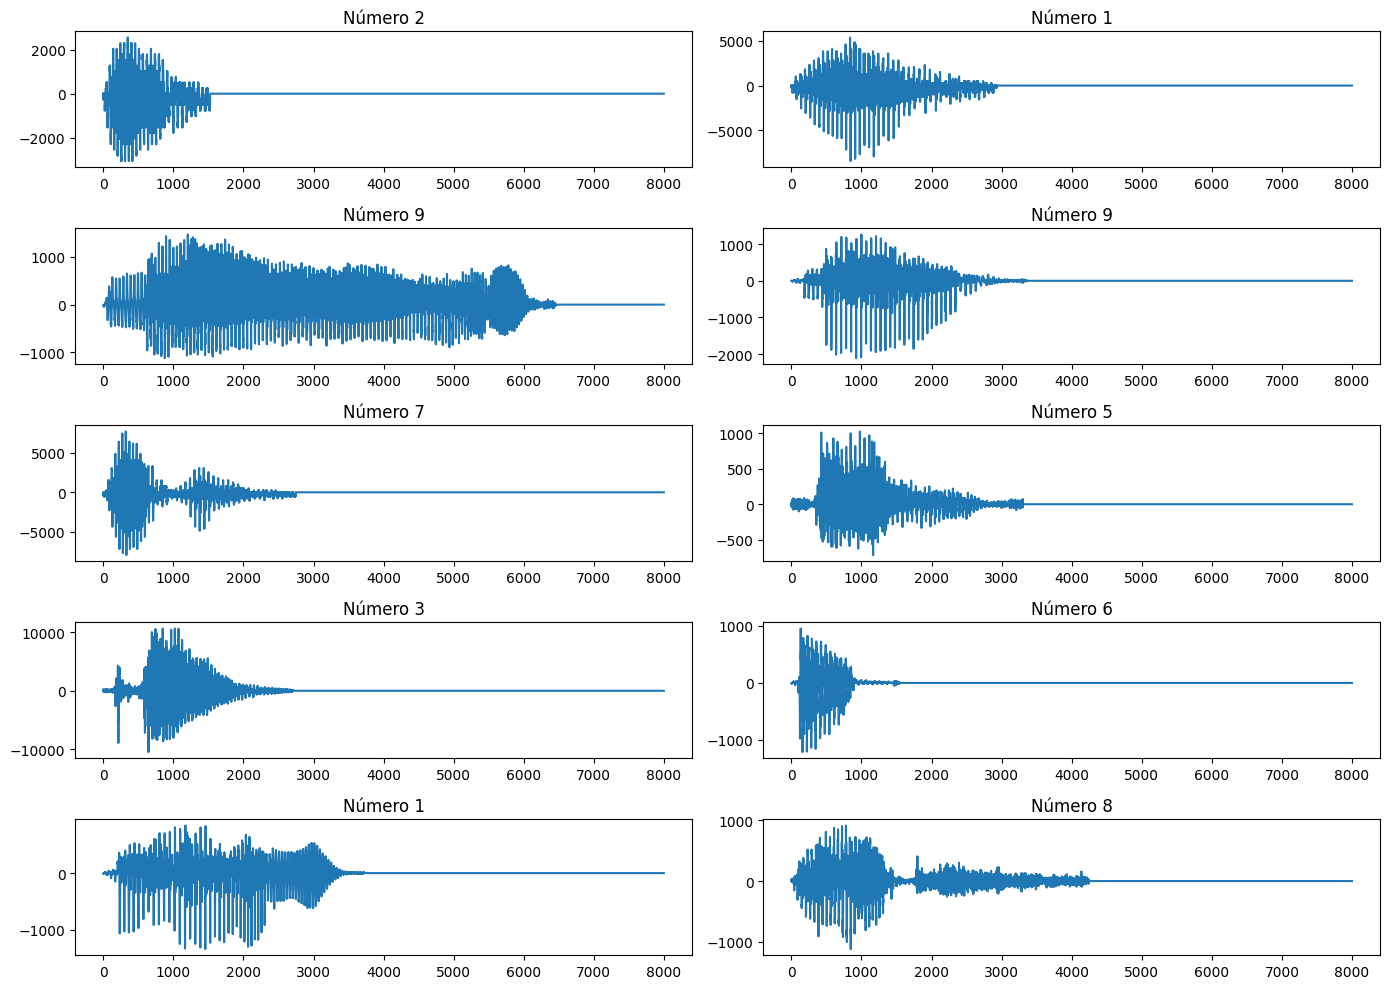

In [8]:
plt.figure(figsize=(14, 10))

for i, example in enumerate(df_train_norm.take(10)):
    audio = example['audio'].numpy()
    label = example['label'].numpy()

    plt.subplot(5, 2, i + 1)
    plt.plot(audio)
    plt.title(f'Número {label}')

plt.tight_layout()
plt.show()

### Se promedian todas las seniales del mismo numoro

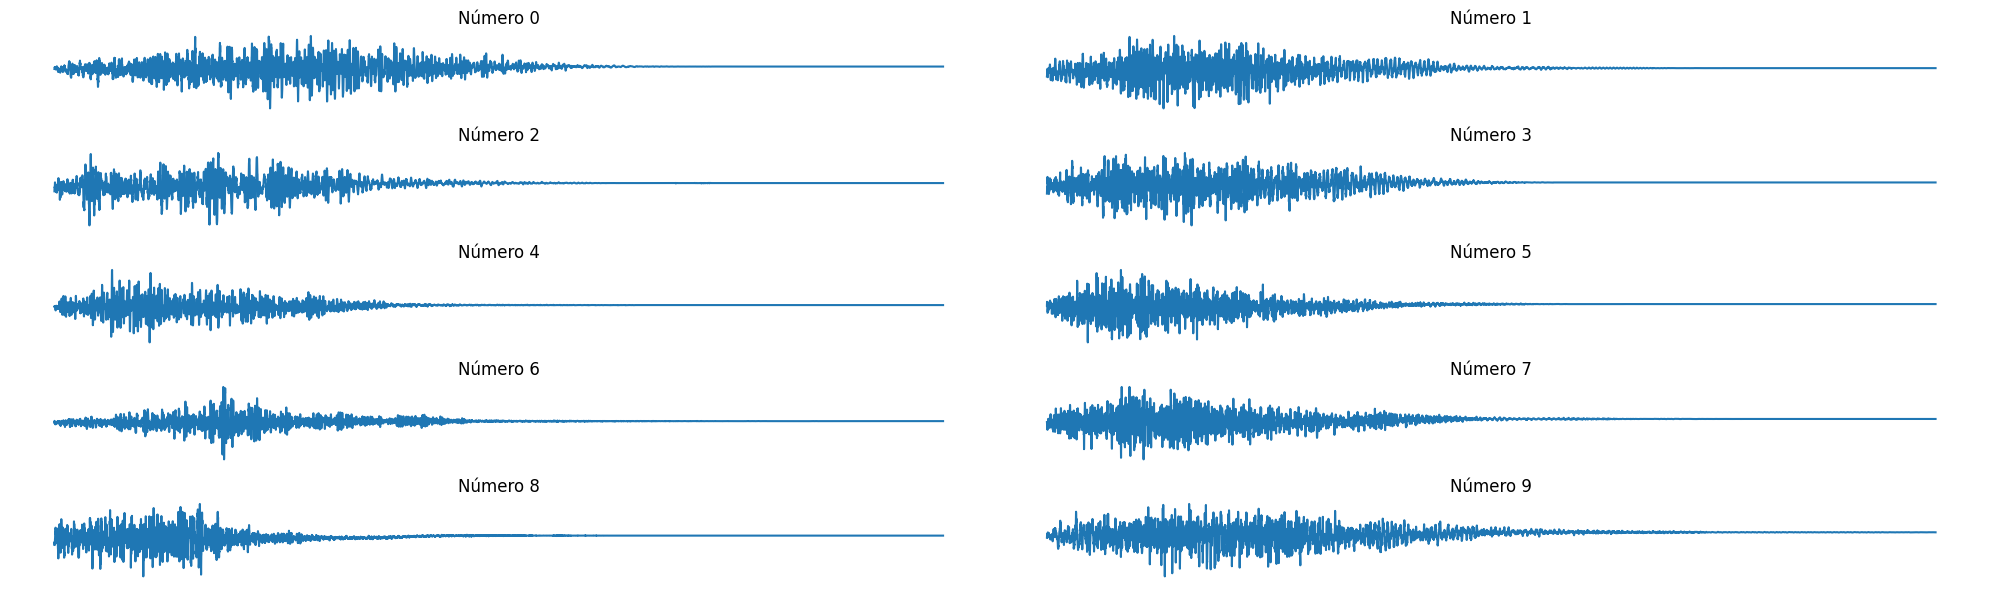

In [9]:
audios_numeros = {i: [] for i in range(10)}

# Recorremos el dataset y almacenamos los audios según su etiqueta
for example in df_train_norm:
    audio = example['audio'].numpy()
    label = example['label'].numpy()
    audios_numeros[label].append(audio)

# Lista para guardar los promedios por dígito
promedios_seniales = []

# Graficar
plt.figure(figsize=(20, 6))
for i in range(10):
    seniales = audios_numeros[i]
    
    if len(seniales) == 0:
        continue  # Evita errores si no hay ejemplos para un número

    # Calcular la longitud promedio
    longitud_promedio = int(np.mean([len(s) for s in seniales]))

    # Ajustar todas las señales a esa longitud
    seniales_ajustadas = []
    for senial in seniales:
        if len(senial) < longitud_promedio:
            senial = np.pad(senial, (0, longitud_promedio - len(senial)), mode='constant')
        else:
            senial = senial[:longitud_promedio]
        seniales_ajustadas.append(senial)

    # Calcular el promedio de señales
    stacked = np.stack(seniales_ajustadas)
    mean_signal = np.mean(stacked, axis=0)
    promedios_seniales.append(mean_signal)

    # Mostrar la señal promedio
    plt.subplot(5, 2, i+1)
    plt.plot(mean_signal)
    plt.title(f"Número {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Se prueba esuchar los promedios de las distitnas seniales de cada numero

In [10]:
for cant_audio in range(len(promedios_seniales)): print(f"audio numero:{cant_audio}"),display.display(display.Audio(promedios_seniales[cant_audio], rate=8000))

audio numero:0


audio numero:1


audio numero:2


audio numero:3


audio numero:4


audio numero:5


audio numero:6


audio numero:7


audio numero:8


audio numero:9


## Convertir formas de onda a espectrogramas

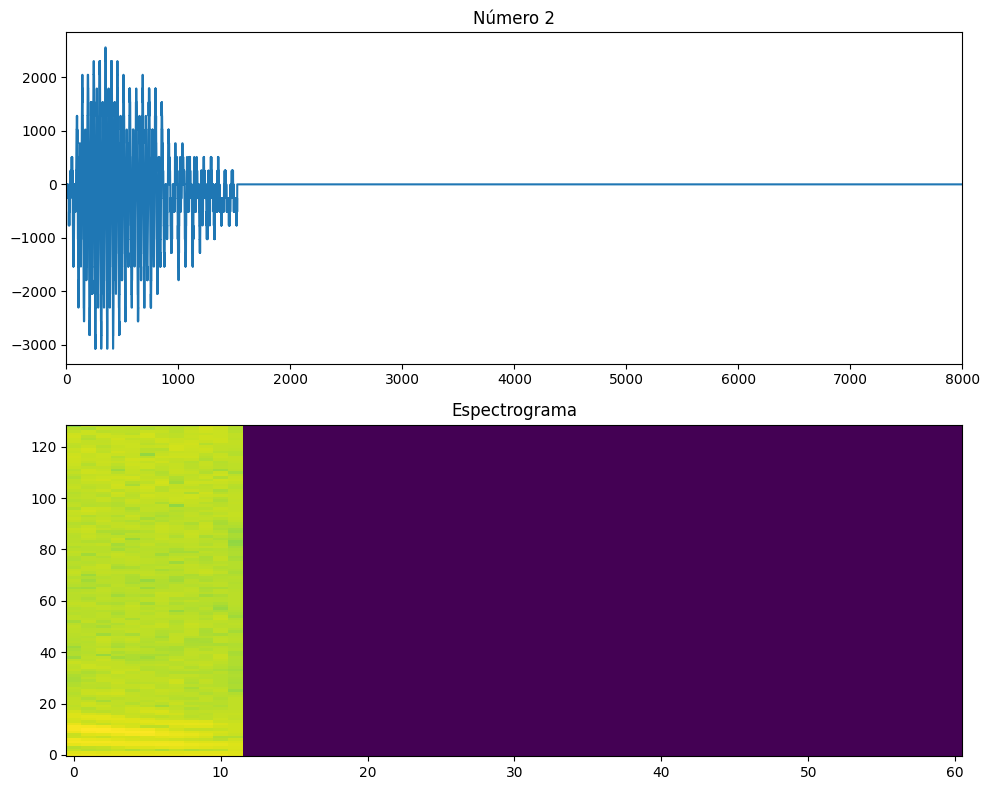

In [11]:
def plot_spectrogram(spectrogram, ax):
    if spectrogram.ndim == 3:
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.arange(width)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

# Suponiendo que get_spectrogram ya está definida
for example in df_train_norm.take(1):
    waveform = example['audio'].numpy()
    label = example['label'].numpy()
    spectrogram = get_spectrogram(waveform).numpy()

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    axes[0].plot(waveform)
    axes[0].set_title(f"Número {label}")
    axes[0].set_xlim([0, len(waveform)])

    plot_spectrogram(spectrogram, axes[1])
    axes[1].set_title("Espectrograma")

    plt.tight_layout()
    plt.show()

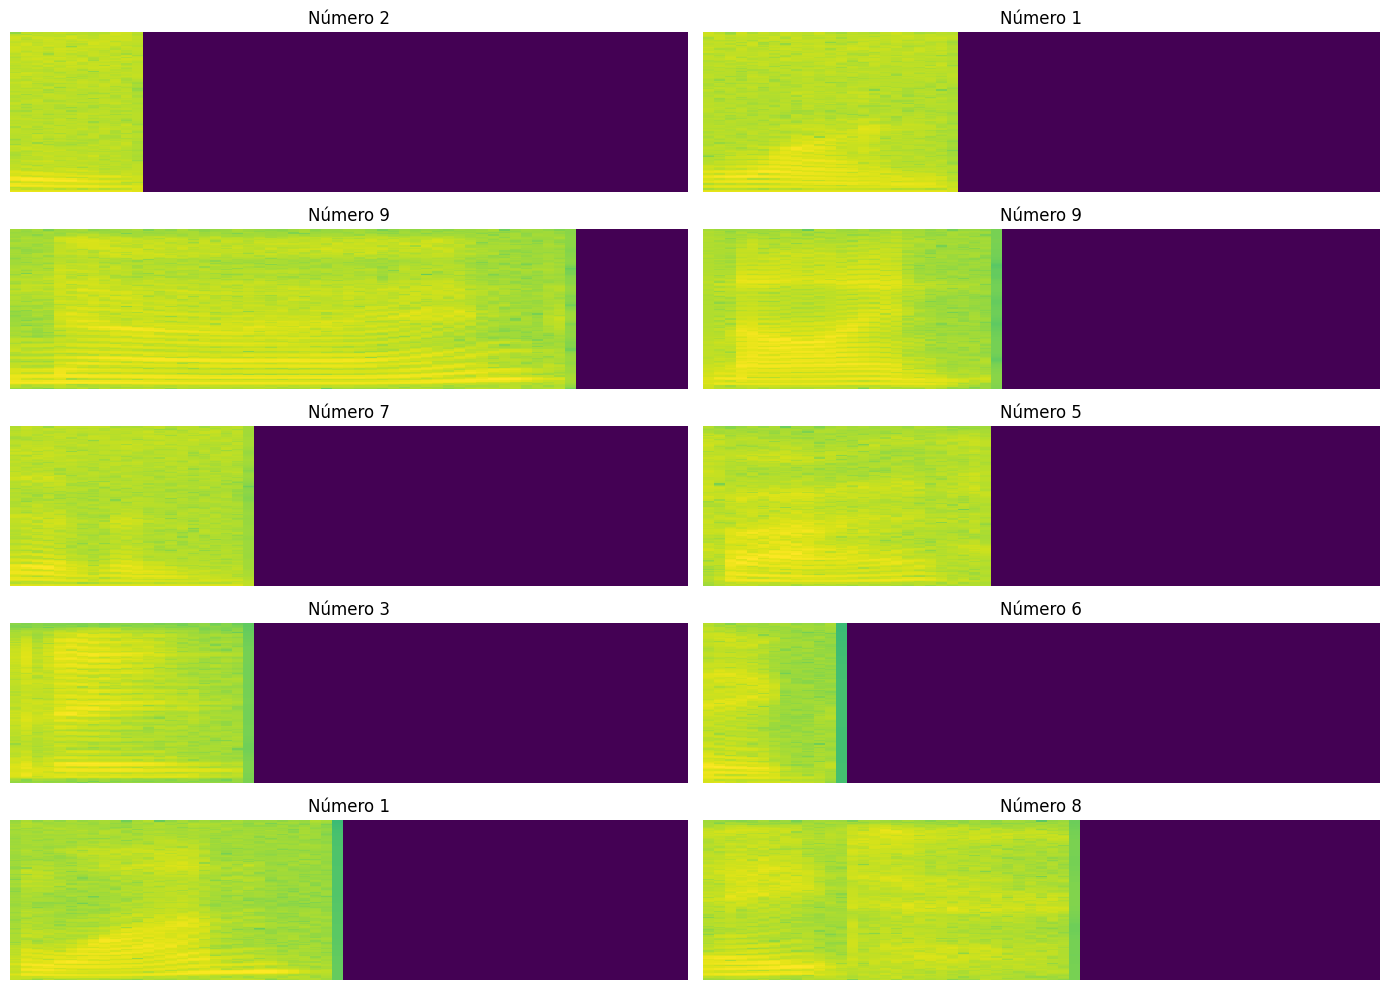

In [12]:
plt.figure(figsize=(14, 10))

for i, example in enumerate(df_train_norm.take(10)):
    audio = example['audio'].numpy()
    label = example['label'].numpy()

    spectrogram = get_spectrogram(audio).numpy()  # Asumimos que esta función ya está definida

    ax = plt.subplot(5, 2, i + 1)
    plot_spectrogram(spectrogram, ax)
    ax.set_title(f'Número {label}')
    ax.axis('off')  # Oculta ejes si querés que se vea más limpio

plt.tight_layout()
plt.show()


In [13]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda dicc: (get_spectrogram(dicc['audio']), dicc['label']),
      num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_spectrogram_ds = make_spec_ds(df_train_norm)
val_spectrogram_ds = make_spec_ds(df_val_norm)

In [15]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### Dataset de espectogramas

In [16]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

2025-06-09 19:45:34.841255: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
train_spectrogram_ds = train_spectrogram_ds.batch(50)
val_spectrogram_ds = val_spectrogram_ds.batch(50)

In [18]:
input_shape = example_spectrograms.shape
print('Input shape:', input_shape)
num_labels = 10

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (61, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50


2025-06-09 19:45:35.950822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-06-09 19:45:36.065425: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2025-06-09 19:45:36.346499: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-09 19:45:36.386970: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58f71461f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-09 19:45:36.387024: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-06-09 19:45:36.400816: I tensorflow/compiler/mlir/tensorflow/utils/du

40/40 [==============================] - 3s 14ms/step - loss: 1.7803 - accuracy: 0.3970 - val_loss: 1.2919 - val_accuracy: 0.5940
Epoch 2/50
40/40 [==============================] - 0s 7ms/step - loss: 1.1358 - accuracy: 0.6335 - val_loss: 0.8973 - val_accuracy: 0.7560
Epoch 3/50
40/40 [==============================] - 0s 7ms/step - loss: 0.8859 - accuracy: 0.7130 - val_loss: 0.7024 - val_accuracy: 0.8280
Epoch 4/50
40/40 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.7745 - val_loss: 0.5538 - val_accuracy: 0.8660
Epoch 5/50
40/40 [==============================] - 0s 7ms/step - loss: 0.5370 - accuracy: 0.8355 - val_loss: 0.4909 - val_accuracy: 0.8920
Epoch 6/50
40/40 [==============================] - 0s 7ms/step - loss: 0.4404 - accuracy: 0.8675 - val_loss: 0.4461 - val_accuracy: 0.8880
Epoch 7/50
40/40 [==============================] - 0s 7ms/step - loss: 0.3729 - accuracy: 0.8810 - val_loss: 0.3740 - val_accuracy: 0.9220
Epoch 8/50
40/40 [============

### Resultados de la red

Text(0, 0.5, 'Accuracy [%]')

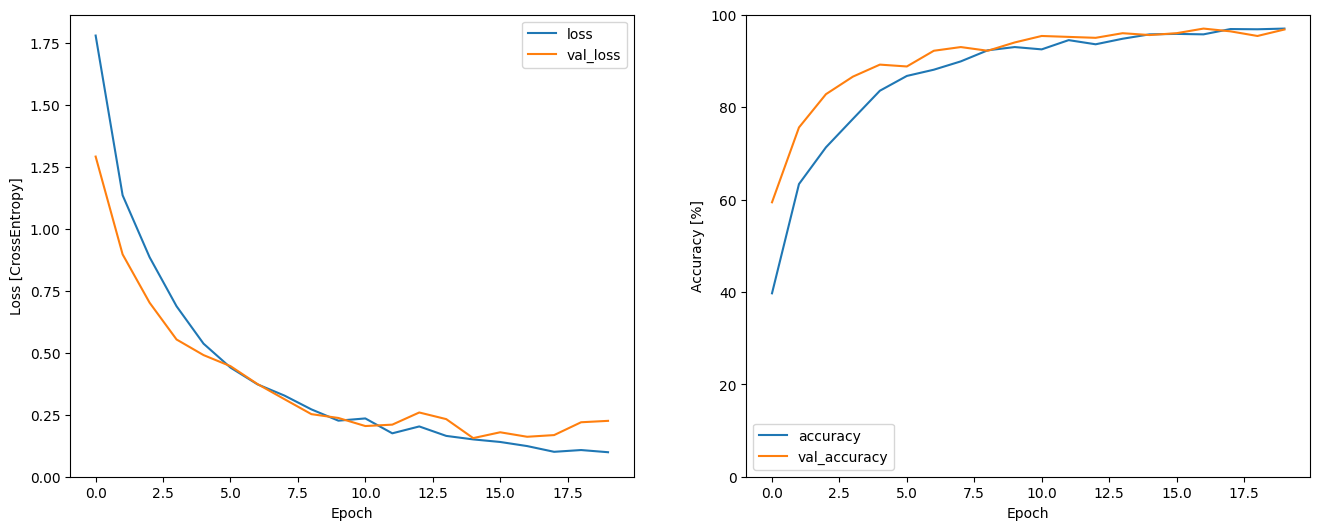

In [20]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

### Matriz de donfucion

10/10 [==============================] - 0s 2ms/step


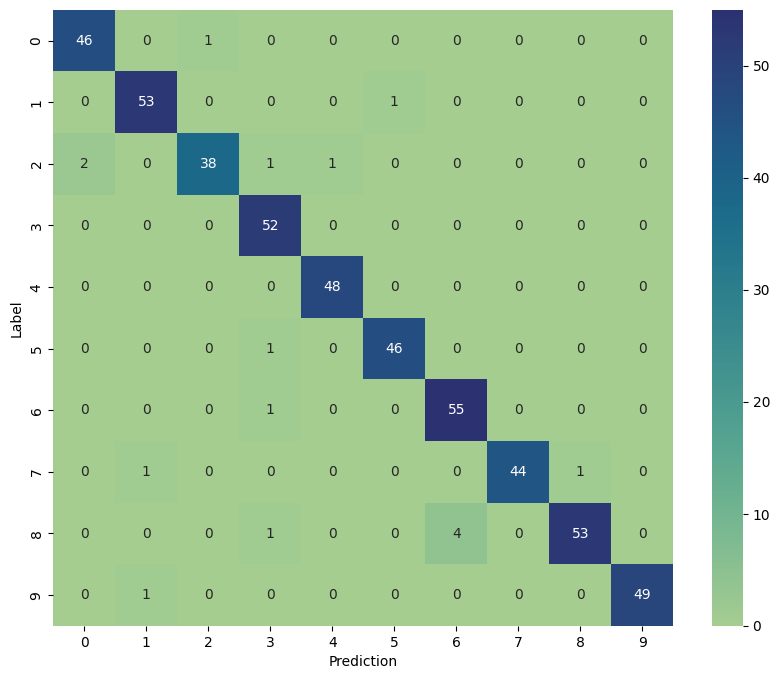

In [21]:
label_names = [i for i in range(10)]

y_pred = model.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='crest')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### Probar con audios de ejemplo

In [22]:
import os

1/1 [==============================] - 0s 98ms/step


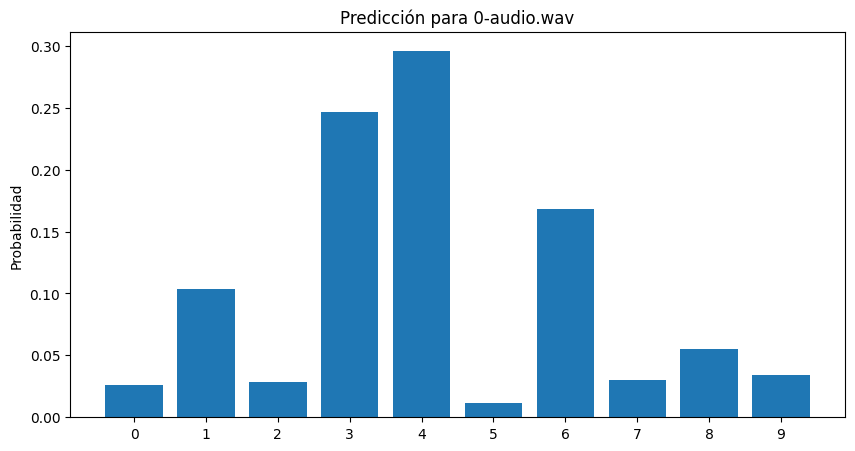

In [23]:
data_dir = 'audios_ejemplo'
audio_ejemplo = '0-audio.wav'

file_path = os.path.join(data_dir, audio_ejemplo)

audio_binary = tf.io.read_file(file_path)

audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=8000)

waveform = tf.squeeze(audio, axis=-1)

spectrogram = get_spectrogram(waveform)

spectrogram = spectrogram[tf.newaxis, ..., tf.newaxis]

prediction = model.predict(spectrogram)

probabilities = tf.nn.softmax(prediction[0])

label_names = [str(i) for i in range(10)]

plt.figure(figsize=(10,5))
plt.bar(label_names, probabilities)
plt.title(f'Predicción para {audio_ejemplo}')
plt.ylabel('Probabilidad')
plt.show()

display.display(display.Audio(waveform.numpy(), rate=sample_rate.numpy()))

## Modelo recurrente

In [42]:
input_shape = example_spectrograms.shape
print('Input shape:', input_shape)
num_labels = 10

norm_layer = layers.Normalization()

norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


model_recurrente = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,
    
    layers.Reshape((64, -1)),
    
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Dropout(0.3),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model_recurrente.summary()

Input shape: (61, 129, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 normalization_5 (Normaliza  (None, 64, 64, 1)         3         
 tion)                                                           
                                                                 
 reshape_4 (Reshape)         (None, 64, 64)            0         
                                                                 
 bidirectional_8 (Bidirecti  (None, 64, 256)           197632    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 64, 256)           0         
                                                                 
 bidirectional_9 (Bidirecti 

In [43]:
model_recurrente.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

history_recurrente = model_recurrente.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8)]
)

Epoch 1/50
40/40 [==============================] - 6s 55ms/step - loss: 1.9439 - accuracy: 0.3140 - val_loss: 1.3144 - val_accuracy: 0.5520
Epoch 2/50
40/40 [==============================] - 1s 30ms/step - loss: 1.0779 - accuracy: 0.6090 - val_loss: 0.6809 - val_accuracy: 0.7680
Epoch 3/50
40/40 [==============================] - 1s 30ms/step - loss: 0.6192 - accuracy: 0.7935 - val_loss: 0.4246 - val_accuracy: 0.8620
Epoch 4/50
40/40 [==============================] - 1s 31ms/step - loss: 0.3956 - accuracy: 0.8715 - val_loss: 0.3822 - val_accuracy: 0.8600
Epoch 5/50
40/40 [==============================] - 1s 32ms/step - loss: 0.2561 - accuracy: 0.9220 - val_loss: 0.3326 - val_accuracy: 0.8860
Epoch 6/50
40/40 [==============================] - 1s 32ms/step - loss: 0.2172 - accuracy: 0.9370 - val_loss: 0.2258 - val_accuracy: 0.9200
Epoch 7/50
40/40 [==============================] - 1s 31ms/step - loss: 0.1891 - accuracy: 0.9510 - val_loss: 0.2301 - val_accuracy: 0.9200
Epoch 8/50
40

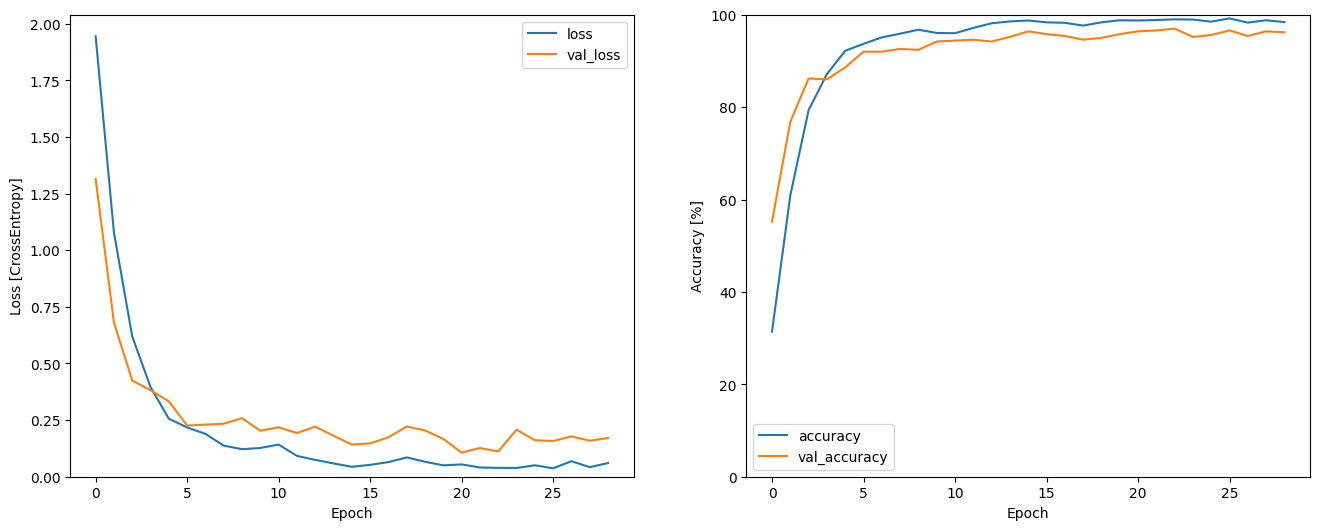

In [44]:
metrics = history_recurrente.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_recurrente.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_recurrente.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

10/10 [==============================] - 1s 25ms/step


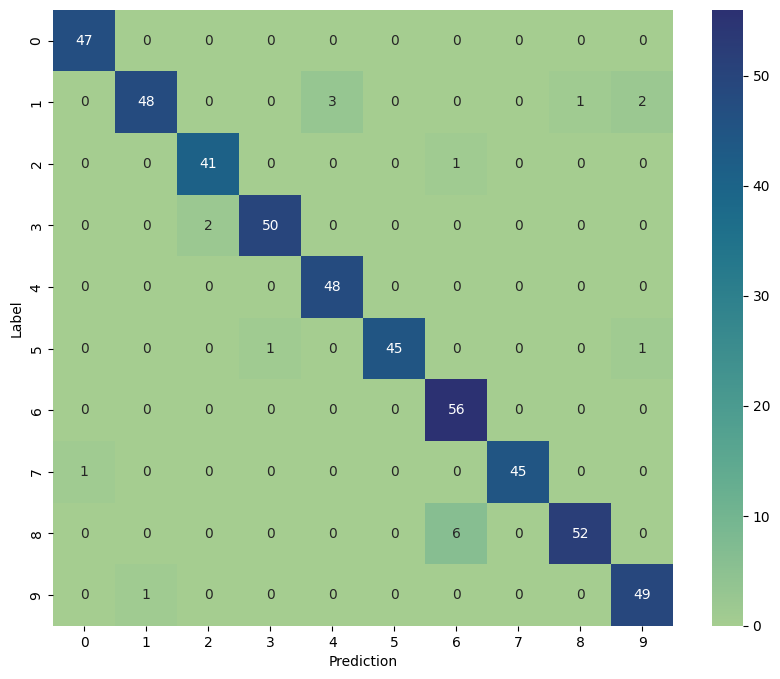

In [41]:
label_names = [i for i in range(10)]

y_pred = model_recurrente.predict(val_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g', cmap='crest')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()